In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import librosa
import scipy

import tensorflow as tf
from tensorflow.python.platform import gfile

import random as rn
np.random.seed(42)
rn.seed(12345)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(1234)


/home/arpith/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/arpith/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/arpith/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/arpith/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:

PATH_TRAIN='/home/arpith/Desktop/nectec/sounds/train'
LABEL_TO_INDEX_MAP={}

In [4]:
###########return classes and assign number to it in training folder#############################
def init(path):
    labels=os.listdir(path) #######list of sub directories in the path
    index=0
    for label in labels:
        LABEL_TO_INDEX_MAP[label]=index   #### initial sub directory name zeroo
        index +=1                         #### increments and assigns next number for next sub directory
    global NUM_LABELS
    NUM_LABELS=len(LABEL_TO_INDEX_MAP)
    return LABEL_TO_INDEX_MAP
init(PATH_TRAIN)

        

{'bad': 1, 'good': 0}

In [5]:
######################encoding those labels #######################################3
def one_hot_encoding(label):
    encoding=[0]*len(LABEL_TO_INDEX_MAP) ############ assigns zeroes initially for length of LABEL_TO_INDEX_MAP (2 places)
    encoding[LABEL_TO_INDEX_MAP[label]]=1  ########### assigns 1 for the presence of the label from LABEL_TO_INDEX_MAP list
    return encoding
print(one_hot_encoding('bad'))


[0, 1]


In [6]:



##################### variance and rms of amplitude(db)############################3
def get_amp_var_rms(wave_path):
    fs_rate, signal = scipy.io.wavfile.read(wave_path)
    signal=librosa.amplitude_to_db(signal) ####### changing freq to amplitude in decibels#####
    variance=np.var(signal) ######## get variance value of the amplitude values
    rms = np.sqrt(np.mean(signal**2))  ########## get rms value of amplitude values
    return variance,rms

#################### centroid of spectrum formed by stft####################3
def get_cent(wave_path):
    y, sr = librosa.load(wave_path)
    S, phase = librosa.magphase(librosa.stft(y))## ############# librosa.stft performs fourier transform on signals
    #### librosa.magphase returns magnitude and phase of complex values extracted from librosa.stft
    cent=np.mean(librosa.feature.spectral_centroid(y=y, sr=sr, S=None, n_fft=4410, hop_length=2205,
                      freq=None).T,axis=0) ### compute spectral centroid of those magnitude values
    

    rolloff=np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, S=None, n_fft=4410, hop_length=2205, freq=None, roll_percent=0.85).T)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y,n_fft=4410,S=None,hop_length=2205).T,axis=0)#3
    mfccs=np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20,n_fft=4410,hop_length=2205,fmin= 50,n_mels=256).T,axis=0) #1

    return mfccs,cent,contrast,rolloff
#    


def get_others(wave_path):
    y, sr = librosa.load(wave_path)   
    stft = np.abs(librosa.stft(y))
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr, S=None, norm=np.inf, n_fft=4410,
                hop_length=2205, tuning=None).T,axis=0)#
    zero_crossing_rate=np.mean(librosa.feature.zero_crossing_rate(y,frame_length=4410,hop_length=2205).T,axis=0)#5
    spectral_flatness=np.mean(librosa.feature.spectral_flatness(y=y,n_fft=4410,S=None,hop_length=2205).T,axis=0)#6

#     others=np.vstack([chroma,zero_crossing_rate,spectral_flatness])
#     roll_off=np.mean(librosa.feature.spectral_rolloff(y=y,n_fft=4410,S=None,hop_length=2205).T,axis=0)
    rmse=np.mean(librosa.feature.rmse(y=y,frame_length=4410,S=None,hop_length=2205).T,axis=0)
    return chroma,zero_crossing_rate,spectral_flatness,rmse



################### extracting mfcc and encode the label #########################
# def get_batch(batch_size,path):    
path=os.path.join(PATH_TEST,"*",'*.wav')  ######## files having path ending with wav
waves=gfile.Glob(path) ### collects all the files existing in the folder(including subdirectories having file ended with .wav)
print(len(waves)) #######length of files#######

#########initialze arrays for each feature###############################
X1=[]
Y=[]
X2=[]
X3=[]
X4=[]
X5=[]
X6=[]
X7=[]
X8=[]
X9=[]
X10=[]
X11=[]
Z=[]
# mfcc,chroma,melspectrogram and spectral contrast
# random.shuffle(waves) #### shuffle the  files( mix of both good and bad files)################

##########get features from each wav file##################################
for wave_path in waves:
    _,label=os.path.split(os.path.dirname(wave_path)) ######splits the subdirectory name from path ##########
    #### _= left out path, label=name of sub directory cutted of from path
    first,second,third,tenth=(get_others(wave_path))  
    fourth,fifth=get_amp_var_rms(wave_path)
    sixth,seventh,eight,nineth=get_cent(wave_path)
#     sixth=get_cent(wave_path)
    X1.append(first)  ### chroma
    X2.append(second) ###  zero
    X3.append(third)  ### spec flatness
    X4.append(fourth) ### amp vars
    X5.append(fifth)  ### amp rms
    X6.append(sixth)  ### MFCC
    X7.append(seventh) ### centroid
    X8.append(eight)    ### contrast  
    X9.append(nineth)  ### rolloff
    X10.append(tenth)  ## rmse
   
    Y.append(label)

########### encode the target values of each wav file##################################
def target(arr):
    yev=[]
    for x in arr:
        if x=='good':
#             print(x)
            yev.append(0)
        else:
#             print(x)
            yev.append(1)
    return yev
#     Z.append(b)

print(target(Y))
Z=target(Y)


98


/home/arpith/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:826: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return (x > x_pad[inds1]) & (x >= x_pad[inds2])
/home/arpith/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
scale=StandardScaler()

x1=np.array(X1)
x2=np.array(X2)
x3=np.array(X3)
four=np.array(X4)
x4=np.reshape(four, (-1, 1))
five=np.array(X5)
x5=np.reshape(five, (-1, 1))
x6=np.array(X6)

x7=np.array(X7)
x8=np.array(X8)

nine=np.array(X9)
x9=np.reshape(nine, (-1, 1))
x10=np.array(X10)
# x11=np.array(X11)


prenormfeat1=np.hstack([x1,x2,x3,x4,x5,x6,x7,x8,x9,x10])


prenormfeat=np.hstack([x1,x2,x3,x4,x5,x6])

# prenormfeat=None
X=None
# X=scaler.fit_transform(prenormfeat)

normfeat=scale.fit_transform(prenormfeat1)

minmaxfeat=scaler.fit_transform(prenormfeat1)


Z=np.array(Z)
# print(X[0])
# print(X.shape)

In [8]:
# print(X[0])
print(normfeat.shape)
print(minmaxfeat.shape)


(98, 46)
(98, 46)


In [9]:
### normality tests for both min-max and normalizied features#######################
from matplotlib import pyplot

print("histogram data by min-max")
pyplot.hist(minmaxfeat)
pyplot.show()
print("histogram data by standard scaler")
pyplot.hist(normfeat)
pyplot.show()

from statsmodels.graphics.gofplots import qqplot
print("qqplot data by min-max")
qqplot(minmaxfeat, line='s')
pyplot.show()

print("qqplot data by standard scaler")
qqplot(normfeat, line='s')
pyplot.show()


from scipy.stats import shapiro
print("shapiro data by min-max")
stat, p = shapiro(minmaxfeat)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

print("shapiro data by standard scaler")   
stat, p = shapiro(normfeat)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')



histogram data by min-max


<Figure size 640x480 with 1 Axes>

histogram data by standard scaler


<Figure size 640x480 with 1 Axes>

qqplot data by min-max


<Figure size 640x480 with 1 Axes>

qqplot data by standard scaler


<Figure size 640x480 with 1 Axes>

shapiro data by min-max
Statistics=0.972, p=0.000
Sample does not look Gaussian (reject H0)
shapiro data by standard scaler
Statistics=0.989, p=0.000
Sample does not look Gaussian (reject H0)


In [10]:
##################### trying to select best features using information gain ################
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
# X_train, X_test, y_train, y_test = train_test_split(minmaxfeat, Z, test_size=0.20)    
selector = SelectKBest(mutual_info_classif, k=46)
X_train_clean = selector.fit_transform(normfeat,Z)
print(X_train_clean)
# X_test_clean = selector.transform(X_test)
# print(X_test_clean.shape)
print(selector.get_support)

[[-0.70860769 -0.43362453  0.21489303 ... -1.63905287  0.51772821
  -1.49149591]
 [ 0.65859855 -0.19580776 -0.12547845 ...  0.67993015 -0.22997247
   0.62679982]
 [-0.55937836 -0.5137225   1.53450016 ... -0.04603967  0.90183379
  -1.09211244]
 ...
 [ 0.8356812   1.5772828  -0.67795767 ...  0.20637647  0.35644116
  -0.0298028 ]
 [-0.16812311  0.4394091   1.51741437 ...  0.64472671  1.95066579
   0.62389789]
 [-0.32013037  1.61685072 -0.32642358 ...  0.33177374 -0.1965963
   0.19161896]]
<bound method SelectorMixin.get_support of SelectKBest(k=46, score_func=<function mutual_info_classif at 0x7f451c7bcbf8>)>


In [11]:
mask = selector.get_support() #list of booleans
new_features = [] # The list of your K best features
names=['chroma1','chroma2','chroma3','chroma4','chroma5','chroma6','chroma7','chroma8','chroma9','chroma10','chroma11','chroma12',
      'zero-cross','spectral-flatness','ampvar','amprms',
       'mfcc1','mfcc2','mfcc3','mfcc4','mfcc5','mfcc6','mfcc7','mfcc8','mfcc9','mfcc10','mfcc11','mfcc12','mfcc13','mfcc14','mfcc15',
       'mfcc16','mfcc17','mfcc18','mfcc19','mfcc20',
      'cent','contrast1','contrast2','contrast3','contrast4','contrast5','contrast6','contrast7','rolloff','rmse']
for bool, feature in zip(mask, names):
    if bool:
        new_features.append(feature)

In [12]:
print(new_features)

['chroma1', 'chroma2', 'chroma3', 'chroma4', 'chroma5', 'chroma6', 'chroma7', 'chroma8', 'chroma9', 'chroma10', 'chroma11', 'chroma12', 'zero-cross', 'spectral-flatness', 'ampvar', 'amprms', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'cent', 'contrast1', 'contrast2', 'contrast3', 'contrast4', 'contrast5', 'contrast6', 'contrast7', 'rolloff', 'rmse']


In [13]:
print(X_train_clean.shape)
# print(X_test_clean[0])

(98, 46)


In [15]:
# note: this for finding kbest features using information gain

# from sklearn.feature_selection import SelectKBest

# selector = SelectKBest(mutual_info_classif, k=10)
# X_train_clean = selector.fit(prenormfeat1, Z)
# # print(X_train_clean.shape)
# # X_test_clean = selector.transform(X_test)
# print(X_train_clean.get_support)

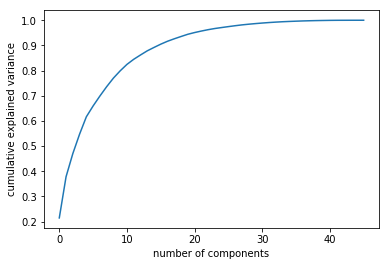

In [16]:
## applying principal component anaysis

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA().fit(X_train_clean)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [17]:
## finally selected 30 features using principal component analysise, because PCA is also good for selecting features #############
from sklearn import decomposition
pca = decomposition.PCA(n_components=30)
PCAfeatures=pca.fit_transform(X_train_clean)

In [18]:
print(PCAfeatures.shape)

(98, 30)


In [19]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import callbacks
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cvscores = []
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
callbacks_list1 = [early_stop]


############# split into training and testing ##########################
x_train, x_test, y_train, y_test=None,None,None,None

# x_train, x_test, y_train, y_test = train_test_split(fs, Z, test_size=0.18)
# from keras.optimizers import Adam
def create_model():
    mod=None
    mod = Sequential()
    mod.add(Dense(8, activation='relu'))
    mod.add(Dropout(0.3))
    mod.add(Dense(4, activation='relu'))
    mod.add(Dropout(0.2))
    mod.add(Dense(1, activation='sigmoid'))
#     adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.09, epsilon=1e-09, decay=0.0)
    mod.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return mod

######################Grid search cv###########################

## this code is for finding good params for neural networks

# create model
# model = KerasClassifier(build_fn=create_model, verbose=0)
# # define the grid search parameters
# batch_size = [5,10,15,20]
# epochs = [50, 100,150]
# model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=5, verbose=0)
# # define the grid search parameters
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# param_grid = dict(optimizer=optimizer)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
# grid_result = grid.fit(X, Z)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))





In [23]:

### LSTM ####

#note: one way to perform LSTM, not yet optimized ####################

# from keras.optimizers import SGD

# from keras.utils import np_utils
# from keras.models import Sequential
# from keras.layers.core import Dense, Activation
# from keras.layers import  Dropout
# from keras.layers.recurrent import LSTM
# from keras.layers import Flatten
# from sklearn.model_selection import train_test_split

# import numpy
# batch_size = 5
# # hidden_units =12 

# def create_dataset(dataset, look_back=1):
# 	dataX= []
# 	for i in range(len(dataset)):
# 		a = dataset[i:(i+look_back), 0]
# 		dataX.append(a)
# # 		dataY.append(dataset[i + look_back, 0])
# 	return numpy.array(dataX)
# x_train, x_test, y_train, y_test = train_test_split(X, Z, test_size=0.18)
# look_back = 1
# trainX = create_dataset(x_train, look_back)
# testX = create_dataset(x_test, look_back)
# # trainX=x_train
# # testX=x_test
# trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# print(trainX.shape)

# model = Sequential()
# model.add(LSTM(output_dim=40, 
#               input_shape=(1,1),return_sequences=True ))
# model.add(Dropout(0.3))
# model.add(LSTM(output_dim=30, 
#               input_shape=(1,1),return_sequences=True ))
# model.add(Dropout(0.5))
# # model.add(LSTM(output_dim=2, 
# #               input_shape=(1,1),return_sequences=True ))
# # model.add(Dropout(0.5))
# model.add(Flatten())

# model.add(Dense(1))
# # model.add(Activation('sigmoid'))

# # sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

# print("Train...")
# model.fit(trainX, y_train, batch_size=batch_size, epochs=1, validation_data=(testX, y_test))
# score, acc = model.evaluate(testX, y_test,
#                             batch_size=batch_size,
#                             )
# print('Test score:', score)
# print('Test accuracy:', acc)

In [25]:
#### kfold cross validaton using neural networks######

X=PCAfeatures

for train, test in kfold.split(X, Z):
  # create model
    model = Sequential()
    model.add(Dense(8,activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    history=model.fit(X[train], Z[train],validation_data=(X[test], Z[test]), epochs=200, batch_size=15, verbose=0,callbacks=callbacks_list1)
    # evaluate the model
    scores = model.evaluate(X[test], Z[test], verbose=0)
#     val_acc = history.history['val_acc']
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

    # history=estimator
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))
X=None

acc: 100.00%
acc: 90.00%
acc: 100.00%
Epoch 00199: early stopping
acc: 100.00%
Epoch 00111: early stopping
acc: 80.00%
Epoch 00018: early stopping
acc: 50.00%
Epoch 00102: early stopping
acc: 90.00%
Epoch 00091: early stopping
acc: 90.00%
Epoch 00022: early stopping
acc: 44.44%
Epoch 00014: early stopping
acc: 88.89%
83.33% (+/- 19.06%)


In [26]:
### the below code is for finding performance metrics, which can be applied to the final selected model afeter model comparisons


# from sklearn import metrics
# T1=metrics.f1_score(y_train, predtrain.round(),  labels=np.unique(predtrain.round()))
# T2=metrics.precision_score(y_train, predtrain.round(),  labels=np.unique(predtrain.round()))
# T3=metrics.recall_score(y_train, predtrain.round(),  labels=np.unique(predtrain.round()))
# T4=metrics.accuracy_score(y_train, predtrain.round())
# print("f1score:",T1)
# print("precision score:",T2)
# print("recall score:",T3)
# print("accuracy score:",T4)

# from sklearn import metrics
# t1=metrics.f1_score(y_test, predtest.round(),  labels=np.unique(predtest))
# t2=metrics.precision_score(y_test, predtest.round(),  labels=np.unique(predtest))
# t3=metrics.recall_score(y_test, predtest.round(),  labels=np.unique(predtest))
# t4=metrics.accuracy_score(y_test, predtest.round())
# print("f1score:",t1)
# print("precision score:",t2)
# print("recall score:",t3)
# print("accuracy score:",t4)


# from sklearn.metrics import confusion_matrix

# from sklearn.metrics import classification_report


# # print(classification_report(y_train, predtrain.round()))
# #              precision    recall  f1-score   support

# cm1 = confusion_matrix(y_train,predtrain.round())
# sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
# print('Sensitivity : ', sensitivity1 )

# specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
# print('Specificity : ', specificity1)

# print(cm1)

# 0.91076923076923078

# from sklearn.metrics import confusion_matrix
# ptest=predtest.ravel()

# cm2 = confusion_matrix(y_test,ptest.round())
# print(cm2)


# sensitivity2 = cm2[0,0]/(cm2[0,0]+cm2[0,1])
# print('Sensitivity : ', sensitivity2 )

# specificity2 = cm2[1,1]/(cm2[1,0]+cm2[1,1])
# print('Specificity : ', specificity2)

In [31]:
# grid search cv for Knearest neigbours #############

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#making the instance
model = KNeighborsClassifier(n_jobs=1)
#Hyper Parameters Set
params = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
#           'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute']
#           'n_jobs':[-1]
         }
#Making models with hyper parameters sets
model1 = GridSearchCV(model,cv=5, param_grid=params, n_jobs=1)
#Learning
X=PCAfeatures
# X_train_clean
model1.fit(X,Z)
#The best hyper parameters set
print("Best Hyper Parameters:\n",model1.best_params_)
print(model1.best_score_)


Best Hyper Parameters:
 {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}
0.8979591836734694


0.10111111111111112
89.89% (+/- 8.95%)
0.13111111111111112
86.89% (+/- 10.02%)
0.10111111111111111
89.89% (+/- 6.33%)
0.10111111111111111
89.89% (+/- 6.33%)
0.09222222222222223
90.78% (+/- 8.62%)
0.12111111111111113
87.89% (+/- 7.46%)
0.10111111111111112
89.89% (+/- 6.33%)
0.11222222222222222
88.78% (+/- 12.39%)
0.0811111111111111
91.89% (+/- 6.05%)
0.09222222222222223
90.78% (+/- 9.71%)
0.10222222222222224
89.78% (+/- 4.49%)
0.12222222222222223
87.78% (+/- 7.44%)
0.13222222222222224
86.78% (+/- 7.74%)
0.14111111111111113
85.89% (+/- 12.78%)
0.11333333333333333
88.67% (+/- 5.77%)
0.13222222222222224
86.78% (+/- 9.20%)
0.09000000000000001
91.00% (+/- 8.31%)
0.10222222222222221
89.78% (+/- 11.18%)
0.09222222222222222
90.78% (+/- 7.37%)


Text(0,0.5,'Mean Error')

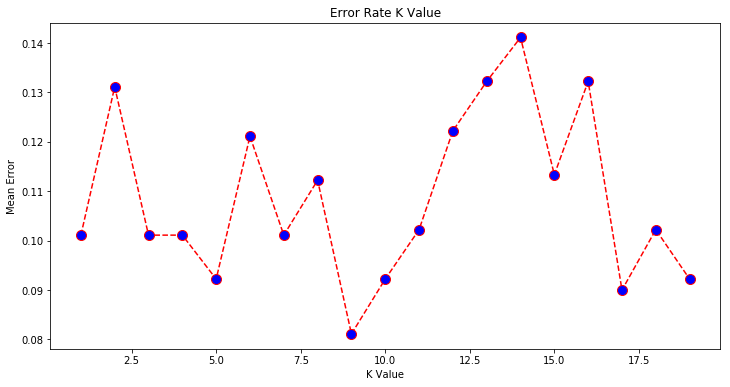

In [33]:
#### #### KNN stratified k-fold cross validation with grid search parameters###########
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy
kfold = StratifiedKFold(n_splits=10, shuffle=True)
cvscores = []
yo='Accuracy'
error=[]
sets=[]
acc=[]
X=PCAfeatures
# X_train_clean


for i in range(1, 20):
    
    error=[]
    #     sets=[]
    cvscores=[]
    for train, test in kfold.split(X, Z):

        classifier = KNeighborsClassifier(n_neighbors=i,weights='uniform',algorithm='auto')  
        classifier.fit(X[train], Z[train])  

        # evaluate the model
        pred_i = classifier.predict(X[test])

        scores=metrics.accuracy_score(Z[test], pred_i.round())
  

        error.append(np.mean(pred_i != Z[test]))

        cvscores.append(scores * 100)
    
    error1=np.array(error)
    error2=np.mean(error1)
    print(error2)
    print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))
    cv=np.mean(cvscores)
    acc.append(cv)
    sets.append(error2)
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 20),sets, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error') 


In [34]:
# ### KNN find optimal k's  when data is split into 80:20#######

# from sklearn.neighbors import KNeighborsClassifier 
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split  
# knnx_train, knnx_test, knnz_train, knnz_test = train_test_split(X_train_clean, Z, test_size=0.18)  
# # error=[] 
# knn=None 

# knn = KNeighborsClassifier(n_neighbors=8,weights='uniform')

# knn.fit(knnx_train, knnz_train)
# pred_i=None
# pred_i = knn.predict(knnx_test)
# scores=None
# scores=metrics.accuracy_score(knnz_test, pred_i.round())
# print(scores)

# plt.figure(figsize=(12, 6))  
# plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',  
#          markerfacecolor='blue', markersize=10)
# plt.title('Error Rate K Value')  
# plt.xlabel('K Value')  
# plt.ylabel('Mean Error') 





In [35]:
### finding best params for RAndom forest classifier ##################
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import matplotlib.pyplot as plt

x_train, x_test,y_train, y_test = train_test_split(X_train_clean, Z, test_size=0.20)  
n_estimators = [1, 5,10,15,20]
train_results = []
test_results = []
max_depths = np.linspace(1, 20, 20, endpoint=True)
min_samples_splits = [2,3,4,5,6,7]
min_samples_leafs = [1,2,3,4,5]
max_features = list(range(1,x_train.shape[1]))

for max_feature in max_features:
    rf = RandomForestClassifier(n_estimators=20,max_depth=4,min_samples_leaf=1,min_samples_split=2,max_features=max_feature, n_jobs=-1,random_state=3)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    scorestr=metrics.accuracy_score(y_train, train_pred.round())

    train_results.append(scorestr)
    y_pred = rf.predict(x_test)
    scoreste=metrics.accuracy_score(y_test, y_pred.round())
    

    test_results.append(scoreste)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

/home/arpith/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/arpith/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [36]:
##Random forest classifier with best params using kfold ########################
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
kfold = StratifiedKFold(n_splits=10, shuffle=True)
cvscores = []
yo='Accuracy'
import numpy
X=PCAfeatures
# X_train_clean


for train, test in kfold.split(X, Z):
  
    classifier =RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, verbose=0, warm_start=False)
    classifier.fit(X[train], Z[train])  

    # evaluate the model
    predtest = classifier.predict(X[test])
    scores=metrics.accuracy_score(Z[test], predtest.round())
    
    print( (scores*100))
    cvscores.append(scores * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

X=None

80.0
80.0
70.0
70.0
90.0
70.0
80.0
90.0
88.88888888888889
77.77777777777779
79.67% (+/- 7.63%)


In [37]:
# random forest classifier without kfold ######
classifier=None
classifier =RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=3, verbose=0, warm_start=False)
classifier.fit(x_train, y_train)  

    # evaluate the model
predtest = classifier.predict(x_test)
scores=metrics.accuracy_score(y_test, predtest.round())
print(scores)

In [39]:
###SVM GridSearchCV##########################
from sklearn.svm import SVC
tuned_parameters = [{'kernel': ['rbf','linear'], 'gamma': [1e-3, 1e-4, 1e-5 , 1e-6 ,1e-7,1e-8] 
                     ,'C': [1, 5 , 10 , 100, 1000,10000,100000,1000000]}]
# grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

clf = GridSearchCV(SVC(), tuned_parameters, cv=10,
                       scoring='accuracy')
X=PCAfeatures
# X_train_clean
clf.fit(X, Z)
print(clf.best_params_)
print(clf.best_score_)


{'C': 10000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.9183673469387755


In [40]:
# SVM with grid search CV parameters############
clf=None
X=X_train_clean
for train, test in kfold.split(X, Z):
    clf = SVC(kernel='rbf',C=1000000, gamma=0.0000001)
    clf.fit(X[train], Z[train])  

    # evaluate the model
    predtest = clf.predict(X[test])
    scores=metrics.accuracy_score(Z[test], predtest.round())
    
    print( (scores*100))
    cvscores.append(scores * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

In [41]:
### SVM without kfold############

# clf=None
# clf = SVC(kernel='rbf',C=1000, gamma=0.001)
# clf.fit(x_train, y_train)  

# # evaluate the model
# predtest = clf.predict(x_test)
# scores=metrics.accuracy_score(y_test, predtest.round())
# print(scores)

1
3848970.7011791845
cost function 3848970.7011791845
2
2320129.7334161163
cost function 2320129.7334161163
3
1400044.252296426
cost function 1400044.252296426
4
1152542.342449516
cost function 1152542.342449516
5
949650.4717197199
cost function 949650.4717197199
6
811933.497835123
cost function 811933.497835123
7
690362.27166746
cost function 690362.27166746
8
642237.5580100624
cost function 642237.5580100624
9
589862.8522852476
cost function 589862.8522852476
10
558227.646722555
cost function 558227.646722555


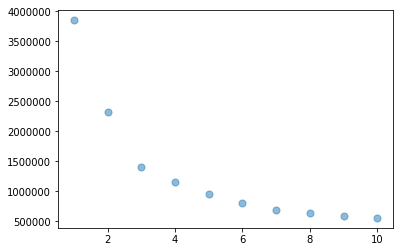

In [44]:
### Unsupervised kmeans to verify number of classes in data #####
from sklearn import decomposition
pca = decomposition.PCA(n_components=36)
# fs=pca.fit_transform(X)

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
kvalsci=[]
distortionssci=[]
kmeans_model=None
O=prenormfeat1
def Wk(mu, clusters):
    K = mu[0].shape
    return sum([np.linalg.norm(mu[i]-c)**2/(2*len(c)) \
               for i in range(K) for c in clusters[i]])

for k in range (1, 11):

    print(k)
    kmeans_model = KMeans(n_clusters=k, tol=0.01).fit(O)
#     print("cluster:",kmeans_model.cluster_centers_)
    interia = kmeans_model.inertia_
   
    print(interia)
    
#     x=Wk(X,kmeans_model.cluster_centers_)
    print("cost function",interia)
#     plt.scatter(O[:,0], O[:,1], c=kmeans_model.labels_, cmap='rainbow')  
#     plt.scatter(kmeans_model.cluster_centers_[:,0] ,kmeans_model.cluster_centers_[:,1], color='black') 
#     plt.show()
    kvalsci.append(k)
    distortionssci.append(interia)
    

plt.scatter(kvalsci[:], distortionssci[:], s=50, alpha=0.5)
plt.show()



In [45]:
####Alternate way toplot k's and score####

# Nc = range(1, 10)

# kmeans = [KMeans(n_clusters=i) for i in Nc]

# kmeans

# score = [kmeans[i].fit(KM).score(KM) for i in range(len(kmeans))]

# score

# plt.plot(Nc,score)

# plt.xlabel('Number of Clusters')

# plt.ylabel('Score')

# plt.title('Elbow Curve')

# plt.show()

In [46]:
# 